In [2]:
from IPython.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>")) # Increase cell width
display(HTML("<style>.rendered_html { font-size: 16px; }</style>")) # Increase font size

# Larger figures
import matplotlib.pyplot as plt
%matplotlib inline  

import warnings
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.metrics import auc, roc_curve, f1_score, accuracy_score, precision_recall_curve, confusion_matrix, classification_report
from sklearn.metrics import recall_score, precision_score
from sklearn import metrics
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import cross_val_score

# Practice #1

Classification trees with Titanic data file

## Data Loading

Variable description:

- **survived:	Survival (target variable) - 0 = No, 1 = Yes**
- pclass:	Ticket class - 1 = 1st, 2 = 2nd, 3 = 3rd
- sex:	    Sex
- age:	    Age in years
- sibsp:	# of siblings / spouses aboard the Titanic
- parch:	# of parents / children aboard the Titanic
- ticket:	Ticket number
- fare:	    Passenger fare
- cabin:	Cabin number
- embarked:	Port of Embarkation - C = Cherbourg, Q = Queenstown, S = Southampton


Let's load the dataset and review null values

In [4]:
import openpyxl

# Red data
filename = 'DATA/titanic.xlsx'
df = pd.read_excel(filename, 1) #it has two sheets, we load the 2nd one
df.head()

,pclass,survived,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,1,1,1,29.0000,0,0,24160,211.3375,B5,2.0
1,1,1,0,0.9167,1,2,113781,151.5500,C22 C26,2.0
2,1,0,1,2.0000,1,2,113781,151.5500,C22 C26,2.0
3,1,0,0,30.0000,1,2,113781,151.5500,C22 C26,2.0
4,1,0,1,25.0000,1,2,113781,151.5500,C22 C26,2.0


In [5]:
print ("Records and variables: ", df.shape)
print ("Column names: ", df.columns.to_list())

Records and variables:  (1309, 10)
Column names:  ['pclass', 'survived', 'sex', 'age', 'sibsp', 'parch', 'ticket', 'fare', 'cabin', 'embarked']


In [6]:
df.isnull().sum() #null values

pclass         0
survived       0
sex            0
age          263
sibsp          0
parch          0
ticket         0
fare           1
cabin       1014
embarked       2
dtype: int64

4 variables with null values, mostly cabin and age. <BR>
We can discard cabin since it appears to be meaningless (and also ticket). <BR> 
We will need to delete records with missing values, otherwise the model will fail

In [7]:
df['ticket'].unique() 

array([24160, 113781, 19952, 13502, 112050, 11769, 'PC 17609', 'PC 17757',
       'PC 17477', 19877, 27042, 'PC 17318', 'PC 17558', 11813, 13050,
       11751, 111369, 'PC 17483', 13905, 11967, 'PC 17760', 110564,
       113784, 112277, 36928, 113783, 110489, 'PC 17608', 113505, 111427,
       113054, 'PC 17591', 112379, 'PC 17610', 16966, 113050, 113798,
       'PC 17476', 'PC 17606', 'PC 17755', 695, 113059, 113760, 19924,
       17770, 'W.E.P. 5734', 113806, 110152, 'PC 17594', 112051, 13508,
       110465, 5727, 'PC 17756', 11770, 113791, 'WE/P 5735', 112901,
       'PC 17599', 113055, 113804, 'F.C. 12750', 17474, 33638, 'PC 17761',
       11755, 'PC 17485', 'PC 17580', 11767, 36947, 'PC 17531',
       'PC 17598', 17421, 'PC 17474', 113051, 19950, 113778, 'PC 17611',
       17765, 13568, 13567, 112058, 113803, 111320, 113503, 112378,
       'PC 17593', 17453, 'PC 17754', 113780, 112053, 'PC 17582',
       'PC 17759', 11765, 'PC 17572', 113796, 36973, 112059, 16988, 12749,
       11

In [8]:
# droppping cabin and ticket
df.drop(labels=['cabin', 'ticket'], axis=1, inplace=True)

Show % of records from each of the survived class (Class 1 = Survived)

In [9]:
from collections import Counter

def class_perc(data):
    lendata = len(data)
    classes = Counter(data)
    
    for sclass, freq in classes.items():
        perc = (freq / lendata) * 100
        print(f"Class '{sclass}': {perc:.2f}%", ", freq:",freq)

class_perc(df['survived'])

Class '1': 38.20% , freq: 500
Class '0': 61.80% , freq: 809


In [10]:
df.isnull().sum()

pclass        0
survived      0
sex           0
age         263
sibsp         0
parch         0
fare          1
embarked      2
dtype: int64

In [11]:
df = df.dropna(subset=['embarked', 'age', 'fare'])
df.describe()

,pclass,survived,sex,age,sibsp,parch,fare,embarked
count,1043.000000,1043.000000,1043.000000,1043.000000,1043.000000,1043.000000,1043.000000,1043.000000
mean,2.209012,0.407478,0.370086,29.813199,0.504314,0.421860,36.603024,1.545542
std,0.840685,0.491601,0.483059,14.366261,0.913080,0.840655,55.753648,0.809366
min,1.000000,0.000000,0.000000,0.166700,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,21.000000,0.000000,0.000000,8.050000,1.000000
50%,2.000000,0.000000,0.000000,28.000000,0.000000,0.000000,15.750000,2.000000
75%,3.000000,1.000000,1.000000,39.000000,1.000000,1.000000,35.077100,2.000000
max,3.000000,1.000000,1.000000,80.000000,8.000000,6.000000,512.329200,2.000000


We are going to split it into training and test (with same class distribution of survived variable in each set)

In [12]:
from sklearn.model_selection import train_test_split

def split_df(dataframe, seed=None, percentage=0.8):
    
    X = df.loc[:, dataframe.columns != 'survived']
    y = df['survived']

    return train_test_split(X, y, test_size=1-percentage, random_state=seed, stratify=y) # note the stratify parameter

X_train, X_test, Y_train, Y_test = split_df(df, seed=42, percentage=0.5)

In [13]:
print("Training data set: ", X_train.shape)
print("Testing data set: ", X_test.shape)
class_perc(Y_train.to_frame(name='survived')["survived"])
class_perc(Y_test.to_frame(name='survived')["survived"])

Training data set:  (521, 7)
Testing data set:  (522, 7)
Class '1': 40.69% , freq: 212
Class '0': 59.31% , freq: 309
Class '0': 59.20% , freq: 309
Class '1': 40.80% , freq: 213


## Classification Tree

In [14]:
from sklearn.tree import DecisionTreeClassifier

titanic_tree = DecisionTreeClassifier(criterion="entropy", random_state=42)
titanic_tree.fit(X_train, Y_train)

DecisionTreeClassifier(criterion='entropy', random_state=42)

Let's take a look to the performance of the classifier (by using initially Accuracy)

In [15]:
pred_train = titanic_tree.predict(X_train)
print("Accuracy of training set = {0:.2%}".format(accuracy_score(Y_train, pred_train)))

pred_test = titanic_tree.predict(X_test)
print("Accuracy of testing set = {0:.2%}".format(accuracy_score(Y_test, pred_test)))

Accuracy of training set = 98.66%
Accuracy of testing set = 74.90%


We can clearly see that our model is **overfitting**

Now we will take a look to the tree itself. <BR>This is a bit complex since sklearn does not provide a way to visualize the models. To that end, we will need to make use of an external library: `pydotplus`.

In [ ]:
# !pip install pydotplus
# !pip install graphviz 
# !pip install io

# you may need to install also this library directly from https://graphviz.gitlab.io/_pages/Download/Download_windows.html 
# and then uncomment following two lines
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin'

from io import StringIO
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

def plot_tree(tree, feature_names):
    dot_data = StringIO()
    export_graphviz(tree, out_file=dot_data, feature_names=feature_names,
                    filled=True, rounded=True,special_characters=True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
    graph.write_png("titanic_train.png")
    return Image(graph.create_png())


<>:8: SyntaxWarning: invalid escape sequence '\P'
<>:8: SyntaxWarning: invalid escape sequence '\P'
C:\Users\SLO\AppData\Local\Temp\ipykernel_21204\2868736094.py:8: SyntaxWarning: invalid escape sequence '\P'
  os.environ["PATH"] += os.pathsep + 'C:\Program Files\Graphviz\bin'


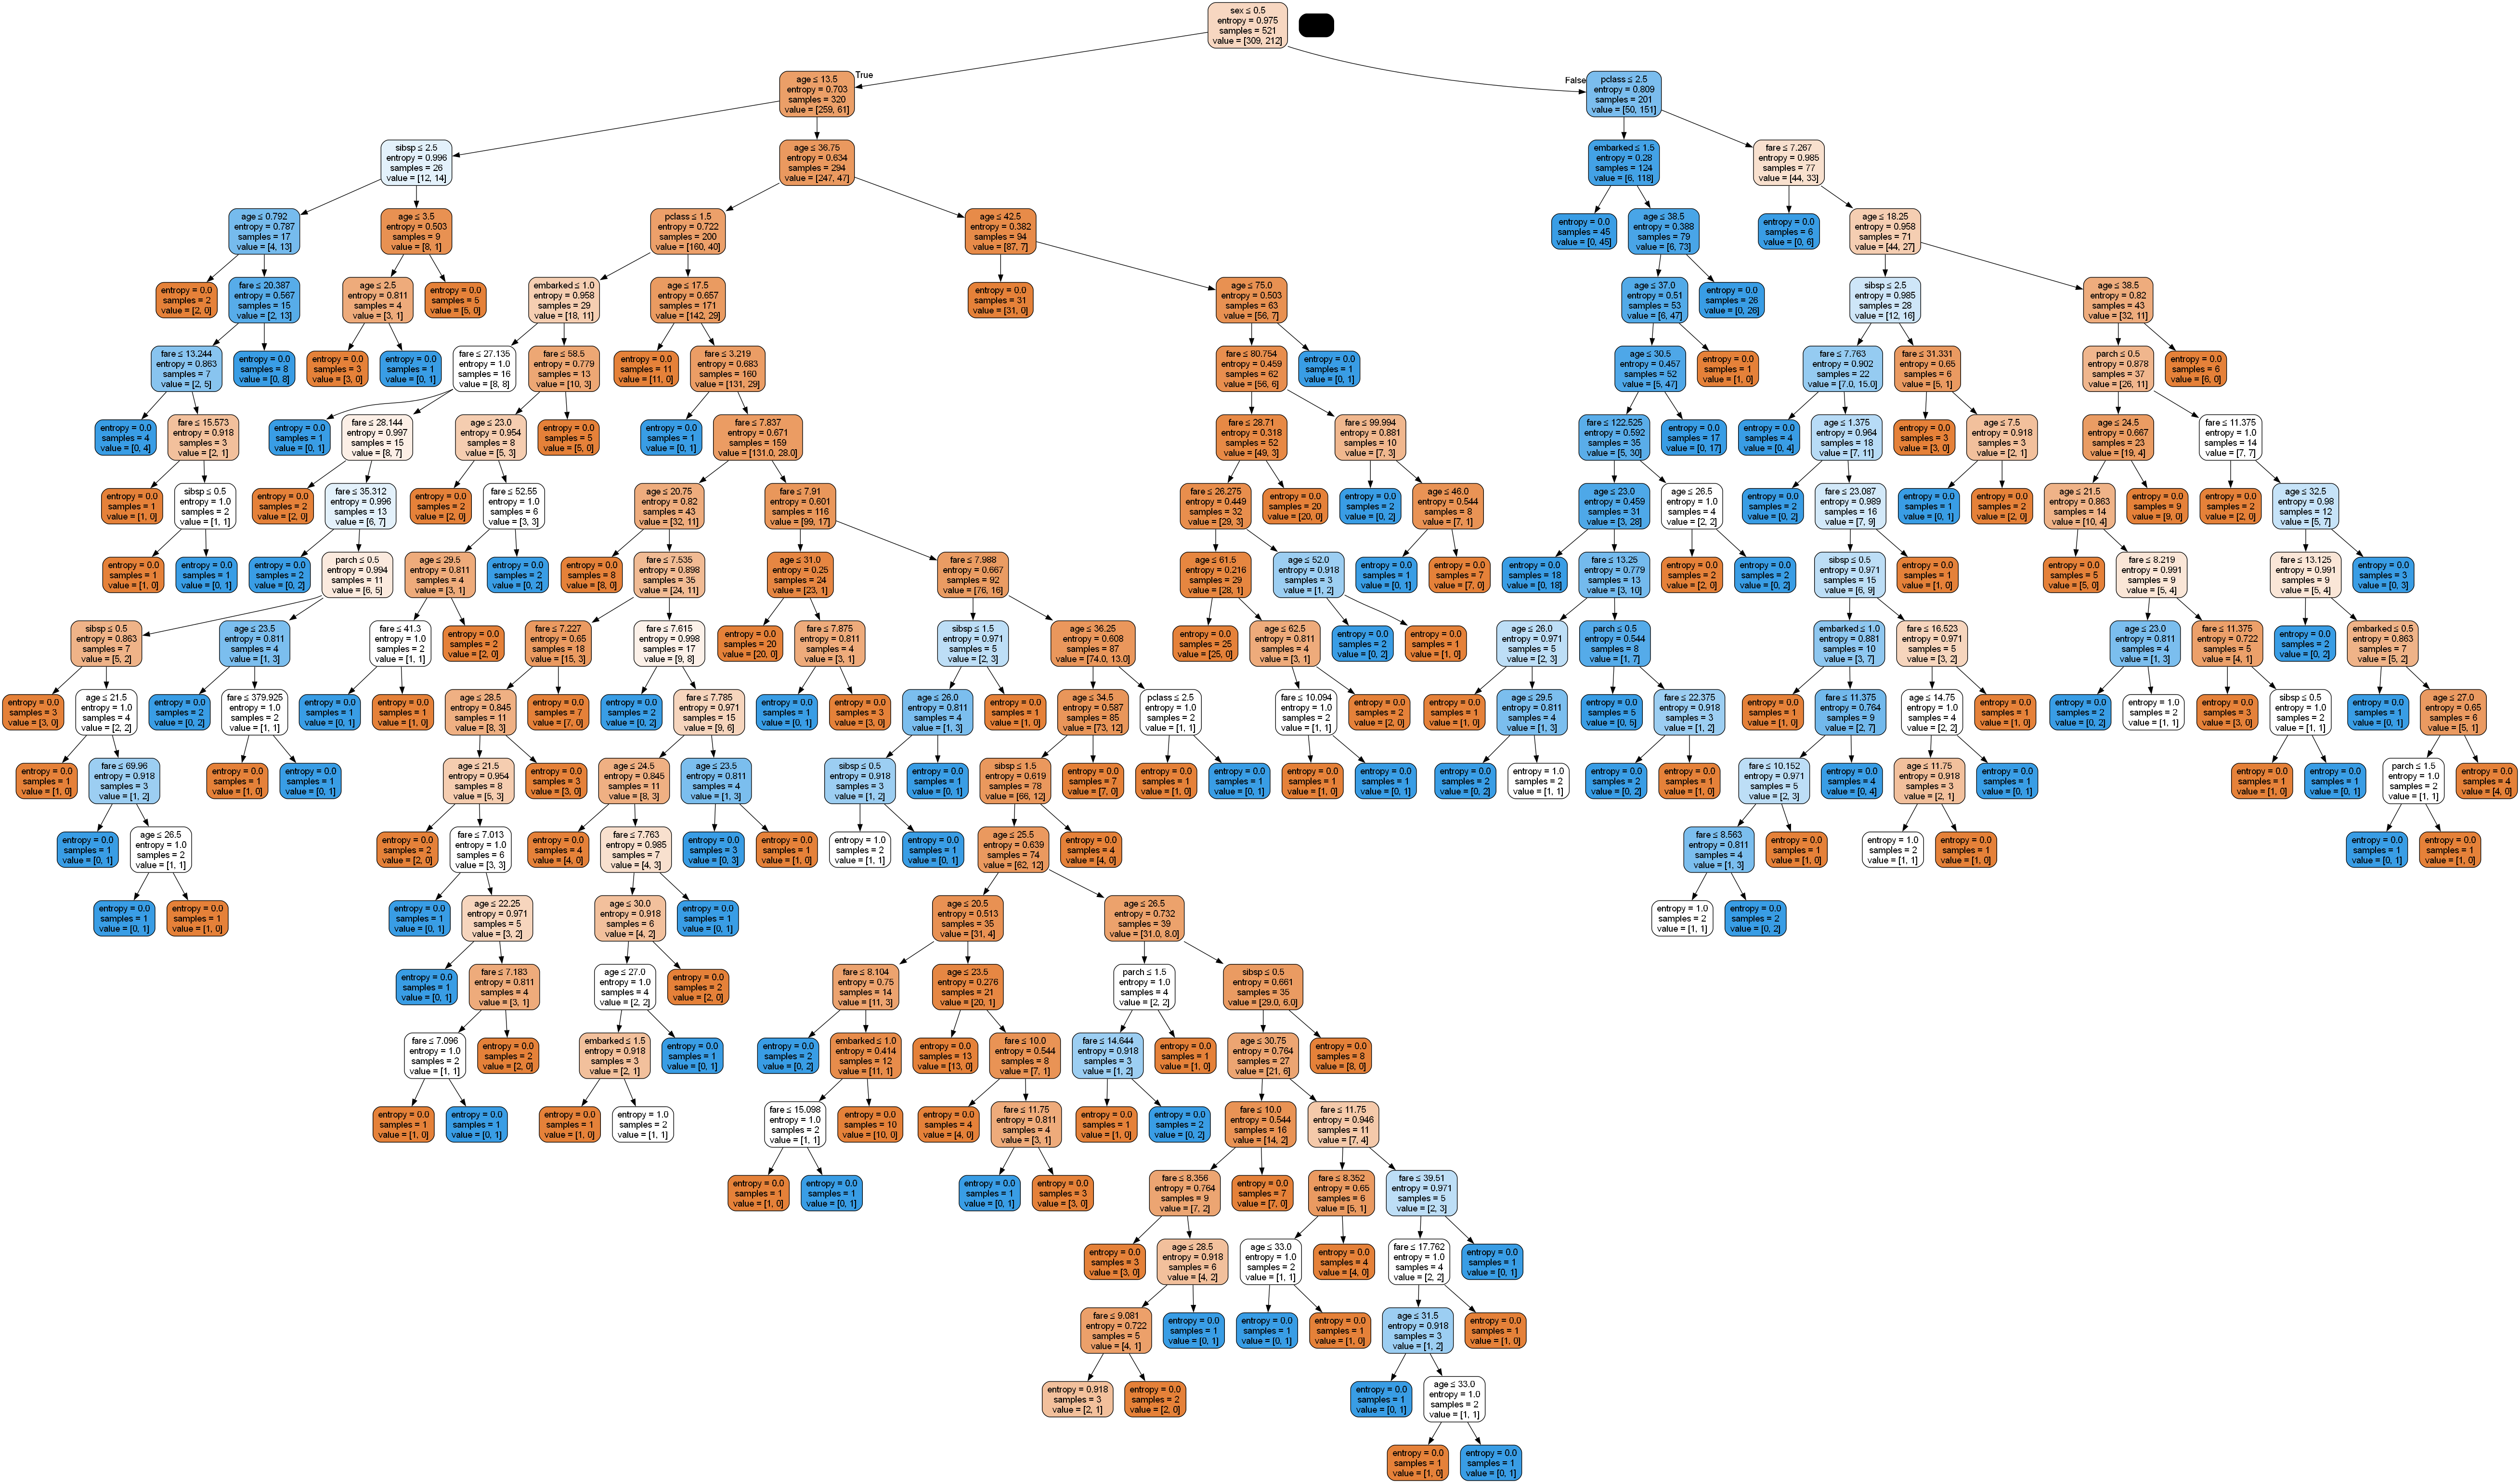

In [ ]:
plot_tree(titanic_tree, X_train.columns)

In [18]:
# We can explore each node, for instance this is root node
root_node=titanic_tree.tree_
node=0
print("Samples: ", root_node.n_node_samples[node])
print("Proportions per class: ",root_node.value[node])
print("Samples per class: ", root_node.value[node]*root_node.n_node_samples[node])
print("Impurity: {0:.2%}".format(root_node.impurity[node]))

Samples:  521
Proportions per class:  [[309. 212.]]
Samples per class:  [[160989. 110452.]]
Impurity: 97.48%


In [ ]:
# How many nodes and leaves?
print("Number of nodes: ", titanic_tree.tree_.node_count)
print("Number of leaves: ", titanic_tree.get_n_leaves())

We will plot the feature importance

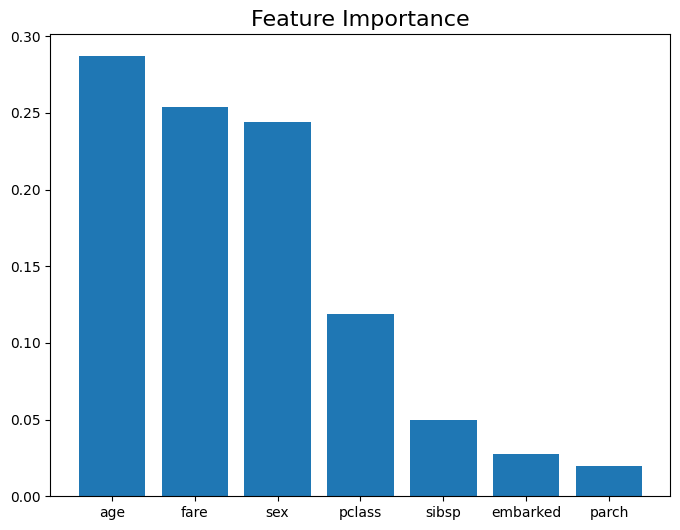

In [19]:
plt.figure(figsize=(8,6))
importances = titanic_tree.feature_importances_
indices = np.argsort(importances)[::-1]
plt.bar(X_train.columns[indices], importances[indices]) #average reduction in impurity resulting from splitting at each node of the tree using that feature
plt.title('Feature Importance', fontsize=16);

## Pruning the tree

The tree, as it is presented, will surely overfit.

Therefore, we will have to prune it to improve performance in the test set.

There are different Pruning Parameters:

 - max_leaf_nodes: Reduce the number of leaf nodes
 - min_samples_leaf: Restrict the size of sample leaf. Minimum sample size in terminal nodes can be fixed to a number or a % of total 
 - max_depth: Reduce the depth of the tree to build a generalized tree. Set the depth of the tree to different values depending after verification on test data
 - etc..

Let's focus for now on the depth of the tree. We will test different depth thresholds via CV (k-fold) by using the `GridSearchCV` provided by sklearn.

In [20]:
from sklearn.model_selection import GridSearchCV

param_grid = {'max_depth': range(1,16)} # 15 different depth levels

titanic_tree_pruned_cv = GridSearchCV(titanic_tree, 
                   param_grid,
                   scoring='accuracy',
                   cv=5 , n_jobs=1, verbose=1)

titanic_tree_pruned_cv.fit(X_train,Y_train);

Fitting 5 folds for each of 15 candidates, totalling 75 fits


In [21]:
print("Best parameters set found on development set:")
print()
print(titanic_tree_pruned_cv.best_params_)
print()
print("Grid scores on development set:")
print()
means = titanic_tree_pruned_cv.cv_results_['mean_test_score']
stds = titanic_tree_pruned_cv.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, titanic_tree_pruned_cv.cv_results_['params']):
    print("Accuracy = %0.3f (+/%0.03f) for %r" % (mean, std * 2, params))

Best parameters set found on development set:

{'max_depth': 3}

Grid scores on development set:

Accuracy = 0.787 (+/0.049) for {'max_depth': 1}
Accuracy = 0.802 (+/0.067) for {'max_depth': 2}
Accuracy = 0.821 (+/0.066) for {'max_depth': 3}
Accuracy = 0.812 (+/0.050) for {'max_depth': 4}
Accuracy = 0.810 (+/0.065) for {'max_depth': 5}
Accuracy = 0.806 (+/0.048) for {'max_depth': 6}
Accuracy = 0.789 (+/0.081) for {'max_depth': 7}
Accuracy = 0.775 (+/0.063) for {'max_depth': 8}
Accuracy = 0.756 (+/0.046) for {'max_depth': 9}
Accuracy = 0.760 (+/0.061) for {'max_depth': 10}
Accuracy = 0.760 (+/0.064) for {'max_depth': 11}
Accuracy = 0.762 (+/0.050) for {'max_depth': 12}
Accuracy = 0.749 (+/0.028) for {'max_depth': 13}
Accuracy = 0.747 (+/0.039) for {'max_depth': 14}
Accuracy = 0.745 (+/0.053) for {'max_depth': 15}


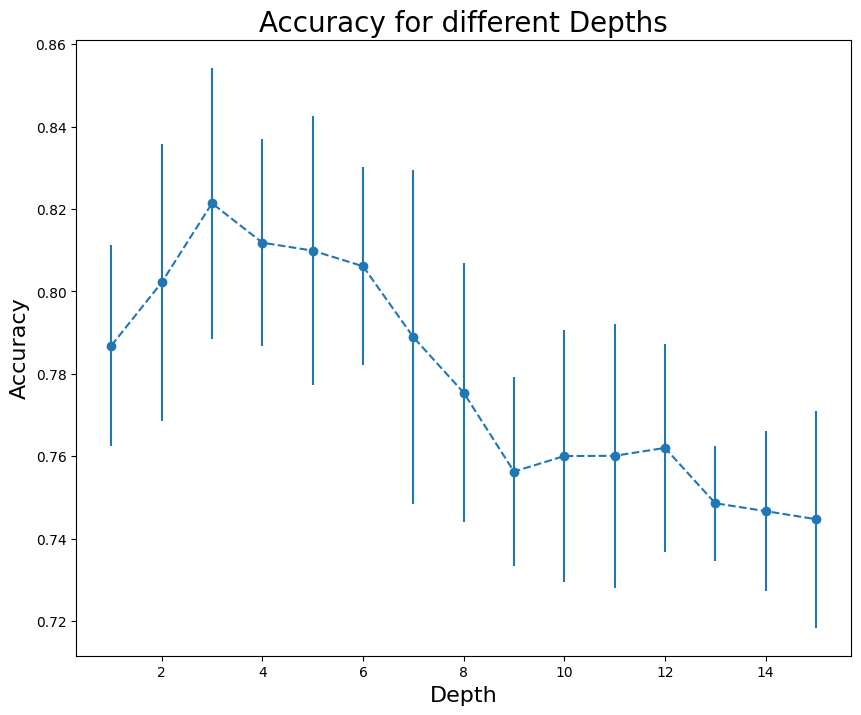

In [22]:
plt.figure(figsize=(10,8))
plt.errorbar(range(1,16,1), [m for m in means], yerr=stds, fmt='--o')
plt.title('Accuracy for different Depths', fontsize=20)
plt.xlabel("Depth", fontsize=16)
plt.ylabel("Accuracy", fontsize=16);

As can be seen in the plot, the optimal value for the depth of the decision tree is 3.

### Test data set

Let's now calculate accuracy for test data set using the depth with maximum accuracy (using a default threshold of 50%)

In [23]:
titanic_tree_pruned = DecisionTreeClassifier(random_state=42, max_depth=3) 
tree=titanic_tree_pruned.fit(X_train, Y_train)

predictions_test = titanic_tree_pruned.predict(X_test) # obtains predictions with a threshold=50%
print("Accuracy = {0:.2%}".format(accuracy_score(Y_test, predictions_test)))

Accuracy = 78.54%


Great! We have increased the accuracy of the test set with a smaller tree.

Now, we represent the different values for the metrics obtained using different thresholds of probabilities

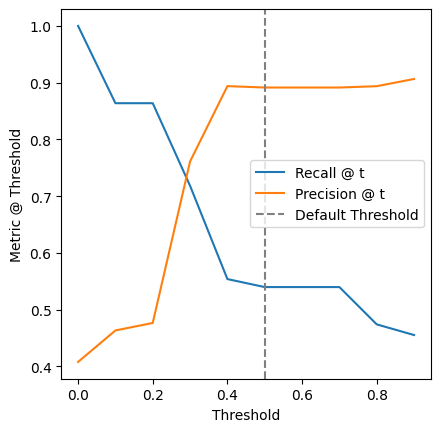

In [24]:
prob_pred = tree.predict_proba(X_test)[:, 1]
thresholds = np.arange(0.0, 1.0, step=0.1)
recall_scores = [metrics.recall_score(Y_test, prob_pred > t) for t in thresholds]
precis_scores = [metrics.precision_score(Y_test, prob_pred > t) for t in thresholds]

fig, ax = plt.subplots(1, 1)
ax.plot(thresholds, recall_scores, label="Recall @ t")
ax.plot(thresholds, precis_scores, label="Precision @ t")
ax.axvline(0.5, c="gray", linestyle="--", label="Default Threshold")
ax.set_xlabel("Threshold")
ax.set_ylabel("Metric @ Threshold")
ax.set_box_aspect(1)
ax.legend()
plt.show()

### Visualization

In [25]:
# How many nodes and leaves?
print("Number of nodes: ", titanic_tree_pruned.tree_.node_count)
print("Number of leaves: ", titanic_tree_pruned.get_n_leaves())

Number of nodes:  15
Number of leaves:  8


And we can represent the set of rules

In [26]:
from sklearn import tree

text_representation = tree.export_text(titanic_tree_pruned, feature_names=list(X_test.columns))
print(text_representation)

# optionally, we can export them to a text file
with open("titanic_pruned.log", "w") as fout:
    fout.write(text_representation)

|--- sex <= 0.50
|   |--- age <= 13.50
|   |   |--- sibsp <= 2.50
|   |   |   |--- class: 1
|   |   |--- sibsp >  2.50
|   |   |   |--- class: 0
|   |--- age >  13.50
|   |   |--- age <= 32.25
|   |   |   |--- class: 0
|   |   |--- age >  32.25
|   |   |   |--- class: 0
|--- sex >  0.50
|   |--- pclass <= 2.50
|   |   |--- age <= 3.50
|   |   |   |--- class: 0
|   |   |--- age >  3.50
|   |   |   |--- class: 1
|   |--- pclass >  2.50
|   |   |--- fare <= 7.74
|   |   |   |--- class: 1
|   |   |--- fare >  7.74
|   |   |   |--- class: 0



Now, we can visualize the pruned tree

In [27]:
import graphviz
# DOT data
dot_data = tree.export_graphviz(titanic_tree_pruned, out_file=None, 
                                class_names=["No","Yes"],
                                feature_names=X_train.columns,  
                                filled=True)

# Draw graph
graph = graphviz.Source(dot_data, format="png") 
graph

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

In [28]:
# Save it into a high resolution image
graph.render("titanic_pruned")

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

## Alternative visualization: dtreeviz
we need to install the powerful library *dtreeviz* for this

In [29]:
!pip install dtreeviz
import dtreeviz

viz_cmodel = dtreeviz.model(titanic_tree_pruned,
                           X_train=X_train,
                           y_train=Y_train,
                           feature_names=X_train.columns,
                           target_name='survived')

viz_cmodel.view(scale=1.5)

Defaulting to user installation because normal site-packages is not writeable


C:\Users\SLO\AppData\Roaming\Python\Python38\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


ExecutableNotFound: failed to execute 'dot', make sure the Graphviz executables are on your systems' PATH

Display now frequencies for each node.<BR>

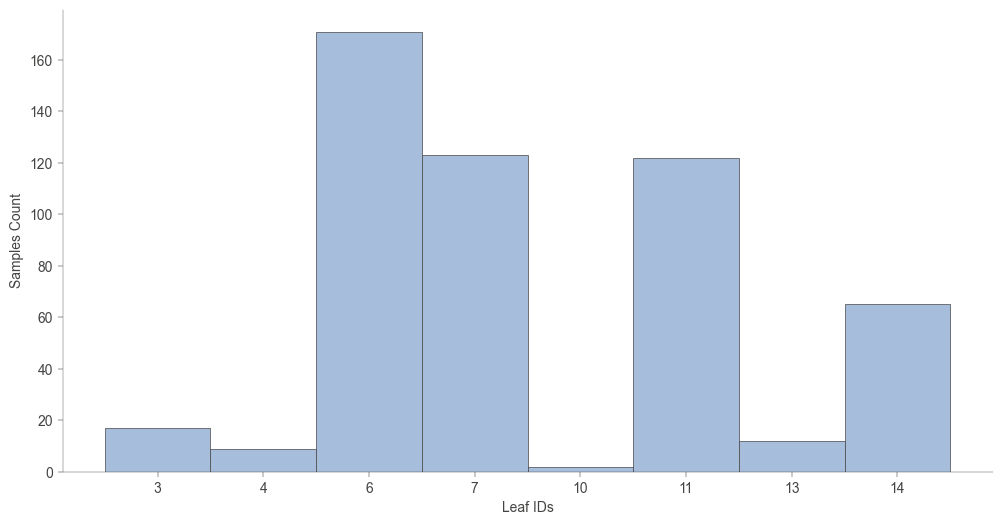

In [30]:
viz_cmodel.leaf_sizes(figsize=(12,6))

We can see node id=6 is the one with maximum amount of people. What about distributions?

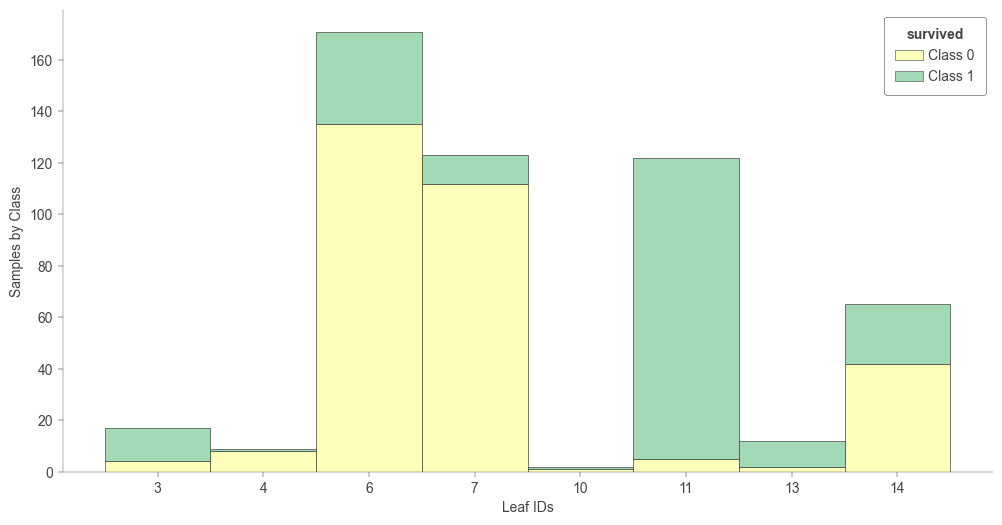

In [31]:
# Compare it with target classes
viz_cmodel.ctree_leaf_distributions(figsize=(12,6))

Let's explore that node

In [32]:
tree = titanic_tree_pruned.tree_
node_samples = tree.n_node_samples
terminal_nodes = [i for i in range(tree.node_count) if tree.children_left[i] == tree.children_right[i]] # terminal nodes: those with no children
max_samples_terminal_node = max(terminal_nodes, key=lambda node: node_samples[node])
print(f"Terminal node with max frequency is {max_samples_terminal_node} with {node_samples[max_samples_terminal_node]} samples.")

Terminal node with max frequency is 6 with 171 samples.


In [33]:
viz_cmodel.node_stats(node_id=max_samples_terminal_node)

,pclass,sex,age,sibsp,parch,fare,embarked
count,171.0,171.0,171.0,171.0,171.0,171.0,171.0
mean,2.532164,0.0,23.98538,0.339181,0.134503,21.988446,1.654971
std,0.721816,0.0,4.772602,0.927766,0.472207,34.002556,0.722102
min,1.0,0.0,14.0,0.0,0.0,0.0,0.0
25%,2.0,0.0,20.0,0.0,0.0,7.8542,2.0
50%,3.0,0.0,24.0,0.0,0.0,8.6625,2.0
75%,3.0,0.0,28.0,0.0,0.0,18.39375,2.0
max,3.0,0.0,32.0,8.0,3.0,263.0,2.0


And highlight it in the tree so that we can take a closer look at it (first we need to look the right index)

In [34]:
decision_paths = titanic_tree_pruned.decision_path(X_train)

indices_in_terminal_node = [i for i in range(len(X_train)) if decision_paths[i, max_samples_terminal_node] == 1]
node = indices_in_terminal_node[0]

In [35]:
x = X_train.iloc[node]
viz_cmodel.view(x=x, scale=1.5)

ExecutableNotFound: failed to execute 'dot', make sure the Graphviz executables are on your systems' PATH

## Model performance

Finally, let's going to analyze model performance (on test data set)

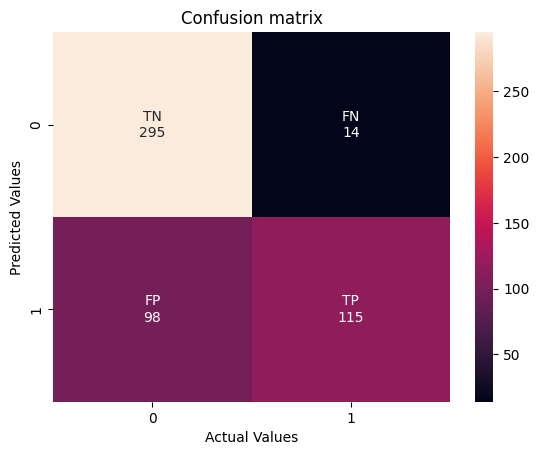

In [36]:
conf_mat = confusion_matrix(Y_test, predictions_test)

fig, ax = plt.subplots()
label_names = ['TN','FN','FP','TP']
label_counts = ['{0:0.0f}'.format(value) for value in conf_mat.flatten()]
labels = [f'{v1}\n{v2}' for v1, v2 in zip(label_names,label_counts)]
labels = np.asarray(labels).reshape(2,2)

# Draw heatmap using confusion matrix
sns.heatmap(conf_mat, annot=labels, fmt='')
ax.set_title('Confusion matrix')
ax.set_xlabel('Actual Values')
ax.set_ylabel('Predicted Values');

Threshold óptimo: 0.35


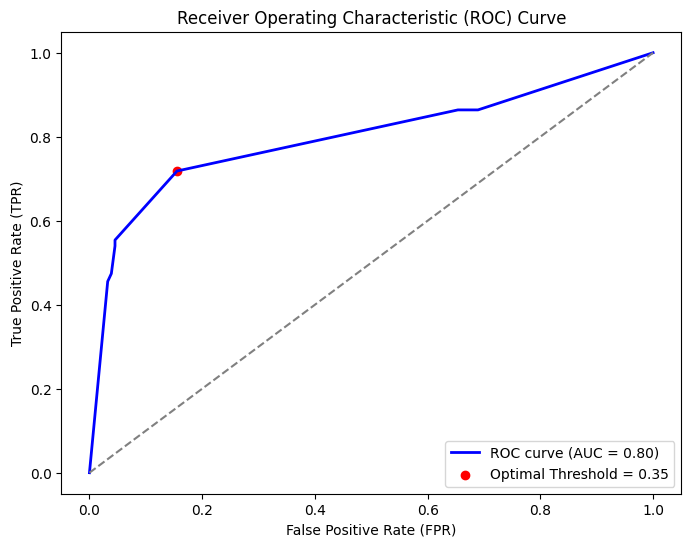

In [ ]:
fpr, tpr, thresholds = roc_curve(Y_test, prob_pred)
roc_auc = auc(fpr, tpr)  
optimal_idx = np.argmax(tpr - fpr)  # Best trade-off between TPR and FPR
optimal_threshold = thresholds[optimal_idx]
print(f"Threshold óptimo: {optimal_threshold:.2f}")

# ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random classification

# Highlight optimal threshold 
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', marker='o',
            label=f'Optimal Threshold = {optimal_threshold:.2f}')

plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show() 